In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/rkube/ml4control'

In [3]:
import logging
from yaml import load, Loader

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt

import sys
# USe the D3D loader to fetch and prepare data
# https://github.com/PlasmaControl/d3d_loaders
sys.path.append("/home/rkube/repos/d3d_loaders")

In [4]:
from d3d_loaders.d3d_loaders import D3D_dataset, Multishot_dataset
from d3d_loaders.samplers import RandomBatchSequenceSampler_multishot, collate_fn_random_batch_seq_multi
from d3d_loaders.samplers import SequentialSamplerBatched, collate_fn_seq_batched

In [5]:
logging.basicConfig(filename="AE_pred_LSTMtest_1723xx.log",
                 filemode='a',
                 format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                 datefmt='%H:%M:%S',
                 level=logging.DEBUG)

In [6]:
with open("AE_prediction_1723xx_small.yaml", "r") as fp:
    config = load(fp, Loader=Loader)
print(config)

{'predictors': ['pinj', 'tinj', 'iptipp', 'dstdenp', 'doutu', 'dssdenest'], 'targets': ['ae_prob'], 'setup': {'tparams': {'tstart': 110.0, 'tend': 2000.0, 'tsample': 1.0}, 'tshift': 20.0}, 'shots': {'train': [172337, 172339, 172341, 172342], 'valid': [172340]}}


In [7]:
# Set up device and dataset parameters.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seq_length = 128
batch_size = 32

## Instantiate training and test datasets

In [8]:
ds_train = Multishot_dataset(config["shots"]["train"], config["setup"]["tparams"],
                             predictors=config["predictors"],
                             targets=config["targets"],
                             shift_targets=dict(zip(config["targets"], [config["setup"]["tshift"]])),
                             datapath="/projects/EKOLEMEN/d3dloader/test", 
                             device=device)

In [9]:
ds_valid = D3D_dataset(config["shots"]["valid"][0], config["setup"]["tparams"],
                            predictors=config["predictors"],
                            targets=config["targets"],
                            shift_targets=dict(zip(config["targets"], [config["setup"]["tshift"]])),
                            datapath="/projects/EKOLEMEN/d3dloader/test", 
                            device=device)

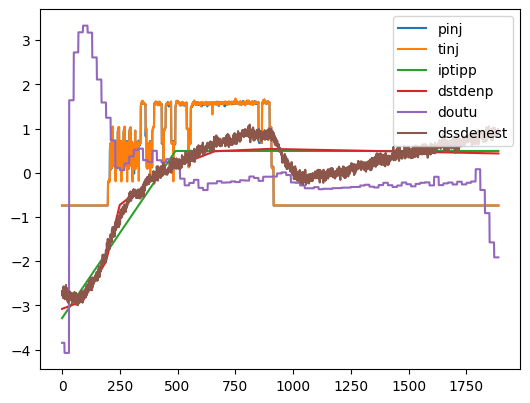

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
for pred in config["predictors"]:
    if pred not in ds_train.shot(0).predictors.keys():
        continue
    plt.plot(ds_train.shot(0).predictors[pred].data.cpu(), label=pred)
    
plt.legend(loc="upper right")

In [11]:
print("Predictors in training set: ", ds_train.shot(0).predictors.keys())
print("Targets in training set: ", ds_train.shot(0).targets.keys())

Predictors in training set:  dict_keys(['pinj', 'tinj', 'iptipp', 'dstdenp', 'doutu', 'dssdenest'])
Targets in training set:  dict_keys(['ae_prob'])


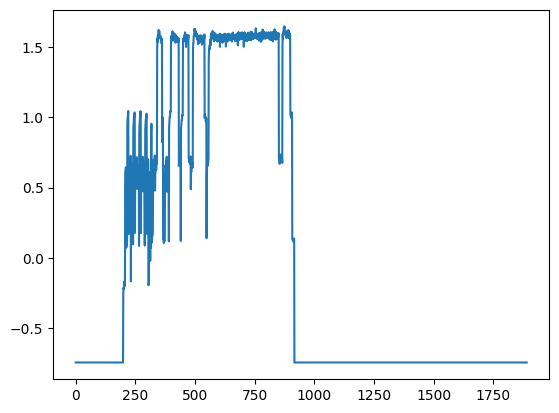

In [12]:
plt.plot(ds_train.shot(0).predictors["pinj"].data.cpu())

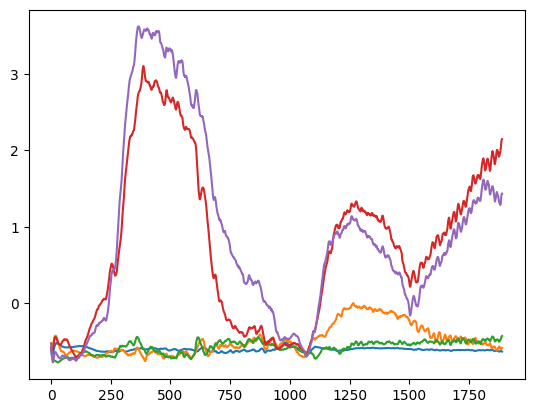

In [13]:
plt.plot(ds_train.shot(0).targets["ae_prob"].data.cpu())

In [14]:
len(ds_train.shot(0))

1890

In [15]:
len(ds_valid)

1890

## Instantiate data loaders

In [16]:
loader_train = torch.utils.data.DataLoader(ds_train, num_workers=0, 
                                           batch_sampler=RandomBatchSequenceSampler_multishot(len(config["shots"]["train"]), len(ds_train.shot(0)), seq_length, batch_size),
                                           collate_fn = collate_fn_random_batch_seq_multi(batch_size))

loader_valid = torch.utils.data.DataLoader(ds_valid, num_workers=0, 
                                           batch_sampler=SequentialSamplerBatched(len(ds_valid), seq_length, batch_size),
                                           collate_fn = collate_fn_seq_batched())

In [17]:
for x, y in loader_train:
    print(x.shape, y.shape)
    L, N, H = x.shape
    print(f"Input to LSTM are tensors of shape (L,N,H) where")
    print(f" L={L} -> sequence length")
    print(f" N={N} -> batch size")
    print(f" H={H} -> input size (= number of predictors)")
    print(f"sequence length is {seq_length} -> should be L-1")
    break



torch.Size([129, 32, 6]) torch.Size([129, 32, 5])
Input to LSTM are tensors of shape (L,N,H) where
 L=129 -> sequence length
 N=32 -> batch size
 H=6 -> input size (= number of predictors)
sequence length is 128 -> should be L-1


In [18]:
for x, y in loader_valid:
    print(x.shape, y.shape)
    L, N, H = x.shape
    print(f"Input to LSTM are tensors of shape (L,N,H) where")
    print(f" L={L} -> sequence length")
    print(f" N={N} -> batch size")
    print(f" H={H} -> input size (= number of predictors)")
    print(f"sequence length is {seq_length} -> should be L-1")
    break

torch.Size([129, 32, 6]) torch.Size([129, 32, 5])
Input to LSTM are tensors of shape (L,N,H) where
 L=129 -> sequence length
 N=32 -> batch size
 H=6 -> input size (= number of predictors)
sequence length is 128 -> should be L-1


In [19]:
class my_lstm(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, seq_length, num_layers=2):
        super(my_lstm, self).__init__()
        self.num_classes = num_classes  # Number of output features
        self.input_size = input_size    # Number of features in the input x
        self.hidden_size = hidden_size  # Number of features in hidden state h
        self.seq_length = seq_length  
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        hn = hn[-1, ...]    # Take output of the last hidden recurrent layer
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out)  # Final Output
        return out

In [20]:
model = my_lstm(5, 6, hidden_size=64, seq_length=seq_length).to(device)

In [21]:
n_param = 0
for param in model.parameters():
    n_param += param.nelement()
print(f"{n_param} parameters")

60677 parameters


In [22]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [23]:
num_epochs = 30

losses_train_epoch = np.zeros(num_epochs)
losses_valid_epoch = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()

    loss_train = 0.0
    loss_valid = 0.0
    for data, target in loader_train:
        optimizer.zero_grad()

        output = model(data[:-1, :, :])

        loss = loss_fn(output, target[-1,:,:])
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
#         #print(f"batch {i}: loss = {loss.item()}")
        
    with torch.no_grad():
        for data, target in loader_valid:
            output = model(data[:-1, :, :])
            loss_valid += loss_fn(output, target[-1, :, :]).item()
    
    losses_train_epoch[epoch] = loss_train
    losses_valid_epoch[epoch] = loss_valid
    print(f"Epoch {epoch}  train loss = {loss_train:8.6e}, valid loss =  {loss_valid:8.6e}")

Epoch 0  train loss = 1.129382e+02, valid loss =  1.976354e+01
Epoch 1  train loss = 7.651058e+01, valid loss =  1.606073e+01
Epoch 2  train loss = 7.420026e+01, valid loss =  1.948557e+01
Epoch 3  train loss = 7.083930e+01, valid loss =  1.136811e+01
Epoch 4  train loss = 6.282440e+01, valid loss =  1.239760e+01
Epoch 5  train loss = 6.229695e+01, valid loss =  1.851246e+01
Epoch 6  train loss = 5.856842e+01, valid loss =  1.246543e+01
Epoch 7  train loss = 5.492373e+01, valid loss =  1.152826e+01
Epoch 8  train loss = 5.718301e+01, valid loss =  1.088545e+01
Epoch 9  train loss = 5.352255e+01, valid loss =  9.151296e+00
Epoch 10  train loss = 4.174453e+01, valid loss =  1.042215e+01
Epoch 11  train loss = 4.380851e+01, valid loss =  1.323958e+01
Epoch 12  train loss = 4.592901e+01, valid loss =  1.221795e+01
Epoch 13  train loss = 4.618963e+01, valid loss =  1.300865e+01
Epoch 14  train loss = 4.175771e+01, valid loss =  1.483079e+01
Epoch 15  train loss = 4.328657e+01, valid loss = 

Text(0, 0.5, 'MSE')

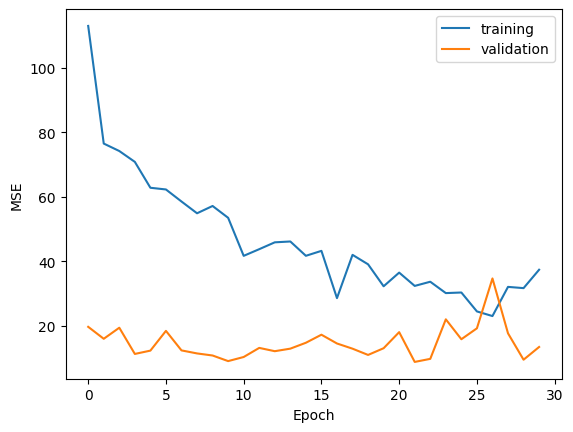

In [24]:
plt.plot(losses_train_epoch, label="training")
plt.plot(losses_valid_epoch, label="validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")

## Evaluate model performance

In [25]:
# Set up reconstructed output
target_pred = torch.zeros(ds_valid.targets["ae_prob"].data.shape)

for i, (data, _) in enumerate(loader_valid):
    output = model(data[:-1, :, :])
    target_pred[(i * batch_size):(i*batch_size)+output.shape[0]] = output[:, :]
target_pred = target_pred.cpu().detach().numpy()

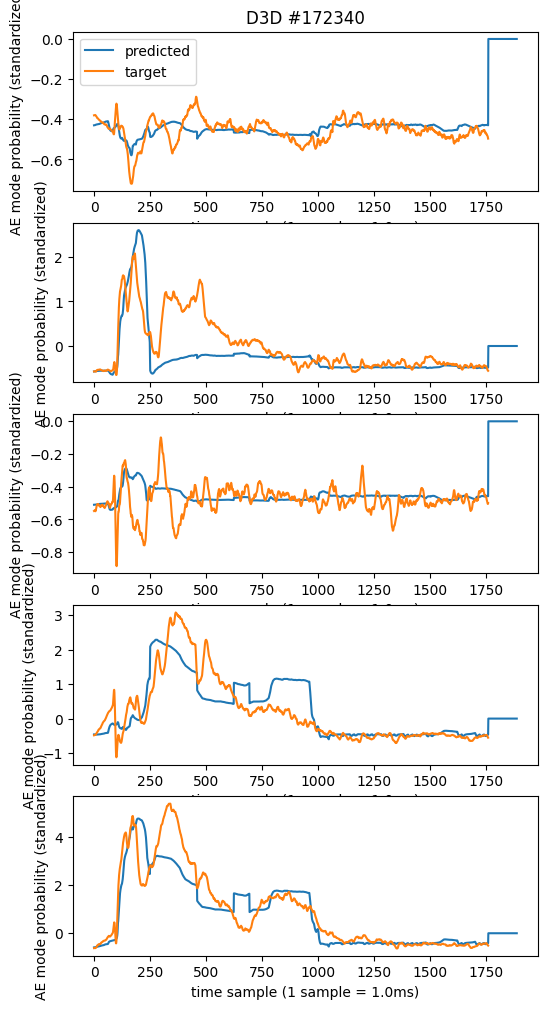

In [26]:
fig = plt.figure(figsize=(6, 12))
for ix_ae in range(0, 5):
    plt.subplot(5, 1, ix_ae + 1)
    
    plt.plot(target_pred[:, ix_ae], label="predicted")
    plt.plot(ds_valid.targets["ae_prob"].data[seq_length:, ix_ae].cpu().detach().numpy(), label="target")
    #plt.plot(ds_valid.predictors["ae_prob"].data[(seq_length - 11):-11, ix_ae].cpu().detach().numpy())
    plt.xlabel(f"time sample (1 sample = {config['setup']['tparams']['tsample']}ms)")
    plt.ylabel("AE mode probability (standardized)")
    if ix_ae == 0:
        plt.legend()
        plt.title(f"D3D #{config['shots']['valid'][0]}")
        
        
fig.savefig("AE_pred_LSTMtest_1723xx.png")